In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

# 数据加载和预处理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 创建成对的数据集
class PairedMNIST(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.indices = list(range(len(mnist_dataset)))
        self.labels = [self.mnist_dataset[idx][1] for idx in self.indices]

    def __getitem__(self, index):
        img1, label1 = self.mnist_dataset[self.indices[index]]

        same_class = np.random.randint(0, 2)
        if same_class:
            label2 = label1
            indices_with_same_class = [i for i, x in enumerate(self.labels) if x == label2]
            img2 = self.mnist_dataset[np.random.choice(indices_with_same_class)][0]
        else:
            label2 = np.random.choice(list(set(self.labels) - {label1}))
            img2 = self.mnist_dataset[np.random.choice([i for i, x in enumerate(self.labels) if x == label2])][0]

        return img1, img2, torch.FloatTensor([int(label1 == label2)])

    def __len__(self):
        return len(self.indices)

# 选取10%的数据
num_train = int(0.1 * len(mnist_train))
num_test = int(0.1 * len(mnist_test))

paired_train_dataset = PairedMNIST(mnist_train)
paired_train_dataset.indices = paired_train_dataset.indices[:num_train]
paired_test_dataset = PairedMNIST(mnist_test)
paired_test_dataset.indices = paired_test_dataset.indices[:num_test]

train_loader = DataLoader(paired_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(paired_test_dataset, batch_size=64, shuffle=False)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



102.8%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



112.7%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [2]:
import torch.nn as nn
import torch.nn.functional as F

# 定义卷积神经网络结构
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64 * 4 * 4, 256)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        return x

# 定义 Siamese 网络结构
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = CNNNet()
        self.fc2 = nn.Linear(256 * 2, 1)

    def forward(self, input1, input2):
        output1 = self.cnn(input1)
        output2 = self.cnn(input2)
        combined = torch.cat((output1, output2), 1)
        output = self.fc2(combined)
        return output

# 实例化模型
model = SiameseNetwork()

Epoch 1, Train Loss: 0.6932, Train Acc: 50.40, Test Loss: 0.6933, Test Acc: 49.00
Epoch 2, Train Loss: 0.6937, Train Acc: 50.33, Test Loss: 0.6927, Test Acc: 52.40
Epoch 3, Train Loss: 0.6933, Train Acc: 49.85, Test Loss: 0.6932, Test Acc: 49.00
Epoch 4, Train Loss: 0.6931, Train Acc: 50.37, Test Loss: 0.6933, Test Acc: 48.70
Epoch 5, Train Loss: 0.6932, Train Acc: 49.67, Test Loss: 0.6933, Test Acc: 46.10
Epoch 6, Train Loss: 0.6931, Train Acc: 51.07, Test Loss: 0.6935, Test Acc: 48.20
Epoch 7, Train Loss: 0.6931, Train Acc: 50.43, Test Loss: 0.6931, Test Acc: 50.70
Epoch 8, Train Loss: 0.6932, Train Acc: 49.53, Test Loss: 0.6932, Test Acc: 49.00
Epoch 9, Train Loss: 0.6932, Train Acc: 50.22, Test Loss: 0.6931, Test Acc: 51.50
Epoch 10, Train Loss: 0.6931, Train Acc: 50.78, Test Loss: 0.6928, Test Acc: 52.50
Epoch 11, Train Loss: 0.6930, Train Acc: 50.98, Test Loss: 0.6938, Test Acc: 47.30
Epoch 12, Train Loss: 0.6933, Train Acc: 49.45, Test Loss: 0.6930, Test Acc: 51.20
Epoch 13, Tra

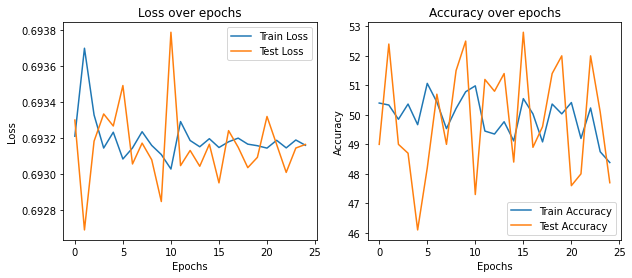

In [4]:
import torch.optim as optim
import matplotlib.pyplot as plt

# 定义训练和测试函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (img1, img2, labels) in enumerate(train_loader):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.sigmoid(outputs).data > 0.5
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (img1, img2, labels) in enumerate(test_loader):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            outputs = model(img1, img2)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted = torch.sigmoid(outputs).data > 0.5
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练和测试模型
num_epochs = 25
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}')

# 可视化训练和测试损失
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 可视化训练和测试准确率
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()